### Remove highly correlated features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pickle as pkl

%matplotlib inline
plt.style.use('ggplot')

from sqlalchemy import create_engine
from tqdm import tqdm
from rdsutils.aws import download_s3 #, python_object_to_s3
from rdsutils.feature_selection import FeatureSelector
import rdsutils.plot as rdsplot

%load_ext autoreload
%autoreload 2

In [2]:
modeling_df = pd.read_parquet('../../artifacts/20201005/modeling_df_w_baseline_preds.parquet')
test_df = pd.read_parquet('../../artifacts/20201005/test_df.parquet')
modeling_df.shape, test_df.shape

((112599, 214), (88890, 207))

In [3]:
modeling_df.ach_target.value_counts()

False    108825
True       3774
Name: ach_target, dtype: int64

In [4]:
modeling_df.ach_target.value_counts()

False    108825
True       3774
Name: ach_target, dtype: int64

In [5]:
fimp_boruta = pkl.load(open('../../artifacts/20201005/fimp_boruta.pkl', 'rb'))
mean_fimp_boruta = fimp_boruta.groupby('feature')['importance'].mean().sort_values(ascending=False).to_frame().reset_index()
features = mean_fimp_boruta.feature.to_list()
removal_order = features[::-1]

(<Figure size 648x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Feature Importance (avg over folds)'}, xlabel='importance', ylabel='feature'>)

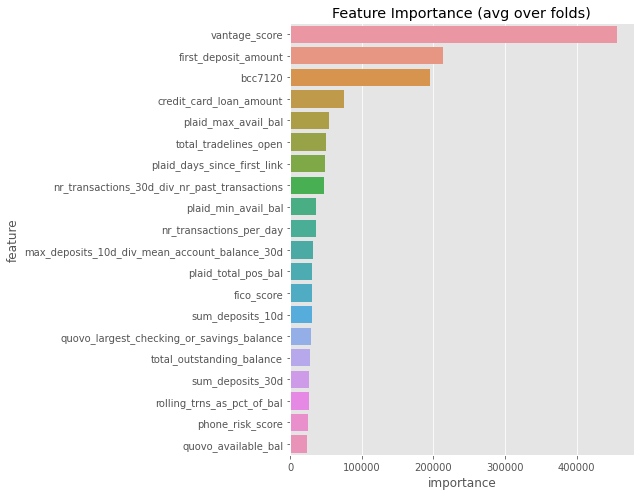

In [6]:
rdsplot.display_feature_importance(mean_fimp_boruta.feature,
                                   mean_fimp_boruta.importance)


### Apply our `FeatureSelector` Class
---

In [7]:
# load back previously saved fsel object
fsel = FeatureSelector(modeling_df, label_cols='ach_target', feature_cols=features)

#### Correlation

In [8]:
modeling_df.columns[modeling_df.columns.str.contains('plaid')]

Index(['plaid_first_link_date', 'plaid_last_link_date', 'plaid_max_avail_bal',
       'plaid_min_avail_bal', 'plaid_total_pos_bal', 'plaid_total_neg_bal',
       'plaid_largest_checking_or_savings_balance', 'plaid_available_bal',
       'plaid_days_since_first_link'],
      dtype='object')

In [9]:
corr = fsel.get_collinear(-0.6, 0.6)

correlation lowerbound: -0.6
correlation upperbound: 0.6
8 features have correlationbeyond bounds provided


In [10]:
fsel.record_collinear_pairs

[('bcc7120', 'all7120', 0.6601122147633398),
 ('plaid_max_avail_bal', 'plaid_total_pos_bal', 0.913328180472549),
 ('fico_score', 'all8220', 0.6614249034603576),
 ('sum_deposits_10d', 'sum_deposits_30d', 0.8402045161557463),
 ('sum_deposits_10d', 'mean_deposits_10d', 0.6733882003174857),
 ('rolling_trns_as_pct_of_bal',
  'transaction_as_pct_of_balance',
  0.9743327345547994),
 ('rolling_trns_as_pct_of_bal',
  'transaction_as_pct_of_bal_min',
  0.9740042281759871),
 ('transaction_as_pct_of_balance',
  'transaction_as_pct_of_bal_min',
  0.9338571154141151)]

#### Remove Highly Correlated Features from Boruta features

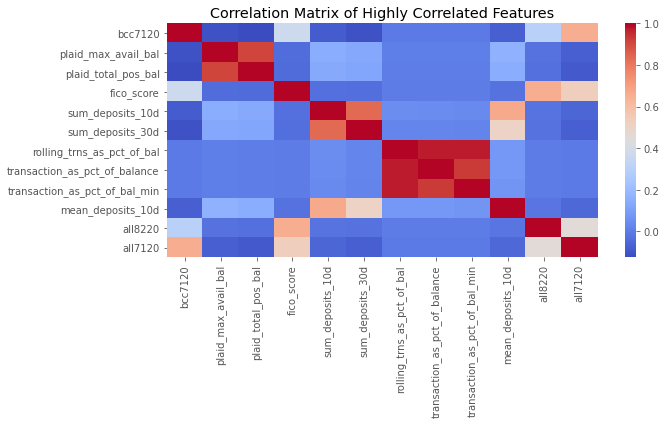

(<Figure size 720x432 with 2 Axes>,
 <AxesSubplot:title={'center':'Correlation Matrix of Highly Correlated Features'}>)

In [11]:
fsel.plot_collinear()

In [12]:
to_drop = fsel.get_collinear_features_to_drop(removal_order)
to_drop

['all7120',
 'all8220',
 'mean_deposits_10d',
 'transaction_as_pct_of_bal_min',
 'transaction_as_pct_of_balance',
 'sum_deposits_30d',
 'plaid_total_pos_bal']

In [13]:
for f in to_drop:
    features.remove(f)

In [14]:
features, len(features)

(['vantage_score',
  'first_deposit_amount',
  'bcc7120',
  'credit_card_loan_amount',
  'plaid_max_avail_bal',
  'total_tradelines_open',
  'plaid_days_since_first_link',
  'nr_transactions_30d_div_nr_past_transactions',
  'plaid_min_avail_bal',
  'nr_transactions_per_day',
  'max_deposits_10d_div_mean_account_balance_30d',
  'fico_score',
  'sum_deposits_10d',
  'quovo_largest_checking_or_savings_balance',
  'total_outstanding_balance',
  'rolling_trns_as_pct_of_bal',
  'phone_risk_score',
  'quovo_available_bal',
  'email_risk_score',
  'deposits_ratio',
  'fraud_score_1',
  'mean_deposits_10d_div_mean_deposits',
  'fraud_score_2',
  'nr_past_deposits',
  'quovo_min_avail_bal',
  'address_risk_score'],
 26)

In [15]:
pkl.dump(features, open('../../artifacts/20201005/features_corr_removed.pkl', 'wb'))